# Análise dos Voos que chegaram adiantados aos destinos

## Importando Bibliotecas

In [4]:
# Ignorar avisos 
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Carragando o Banco de Dados

In [6]:
df = pd.read_csv('DelayedFlights.zip')

## Análise Preliminar dos dados

In [7]:
df['Year'].unique() # só ha valores de 2008

array([2008], dtype=int64)

In [8]:
# Excluindo a primeira coluna
df = df.drop(df.columns[:1], axis=1)

In [9]:
# Excluindo colunas que não serão utilizadas na análise
df.drop(['Year','TaxiIn', 'TaxiOut', 'TailNum', 'FlightNum', 'UniqueCarrier',
        'DepTime', 'CRSDepTime','ArrTime','CRSArrTime'], # horários
                       axis=1, inplace=True)

In [10]:
print('Verificando se há valores de tempo negativos')
print('ActualElapsedTime',len(df[df['ActualElapsedTime']<0]['ActualElapsedTime']))
print('CRSElapsedTime',len(df[df['CRSElapsedTime']<0]['CRSElapsedTime']))
print('AirTime',len(df[df['AirTime']<0]['AirTime']))

Verificando se há valores de tempo negativos
ActualElapsedTime 0
CRSElapsedTime 6
AirTime 0


In [11]:
print('Verificando se há valores de tempo zerados ou negativos')
print('ActualElapsedTime',len(df[df['ActualElapsedTime']<=0]['ActualElapsedTime']))
print('CRSElapsedTime',len(df[df['CRSElapsedTime']<=0]['CRSElapsedTime']))
print('AirTime',len(df[df['AirTime']<=0]['AirTime']))

Verificando se há valores de tempo zerados ou negativos
ActualElapsedTime 0
CRSElapsedTime 6
AirTime 7


- 'CRSElapsedTime' registra o tempo de voo programado em minutos, valores negativos e nulos são valores incosistentes, logo, precisam ser retirados.

In [12]:
df = df[df['CRSElapsedTime']>0]

Valores Zerados ou são de voos cancelados, Desviados ou são registros errados

In [13]:
# Filtrando voos não cancelados
df = df[df['Cancelled']==0]
# como já foi retirado os cancelados, não precisa manter a coluna de cancelados e seus motivos
df.drop(['Cancelled','CancellationCode'],axis=1, inplace=True)
# filtrando os voos não desviados
df = df[df['Diverted']==0]
df.drop(['Diverted'],axis=1, inplace=True)


observação:
- Voos Cancelados foram analisados no arquivo 'analise_cancelados.ipynb'
- Voos Desviados foram analisados no arquivo 'analise_desviados.ipynb'

In [14]:
print('Verificando se há valores de tempo zerados ou negativos')
print('ActualElapsedTime',len(df[df['ActualElapsedTime']<=0]['ActualElapsedTime']))
print('CRSElapsedTime',len(df[df['CRSElapsedTime']<=0]['CRSElapsedTime']))
print('AirTime',len(df[df['AirTime']<=0]['AirTime']))

Verificando se há valores de tempo zerados ou negativos
ActualElapsedTime 0
CRSElapsedTime 0
AirTime 7


como o AirTime ainda apareceu valores inconsistentes, foram retirados do df

In [15]:
df= df[df['AirTime']>0]

In [16]:
# verificando se foram retirados todos os dados zerados nas colunas especificadas
print('Verificando se há valores de tempo zerados')
print('ActualElapsedTime',len(df[df['ActualElapsedTime']<=0]['ActualElapsedTime']))
print('CRSElapsedTime',len(df[df['CRSElapsedTime']<=0]['CRSElapsedTime']))
print('AirTime',len(df[df['AirTime']<=0]['AirTime']))

Verificando se há valores de tempo zerados
ActualElapsedTime 0
CRSElapsedTime 0
AirTime 0


Verificar a quantidade de linhas com valores nulos

In [17]:
df.isnull().sum().sort_values(ascending=False)

CarrierDelay         680881
WeatherDelay         680881
NASDelay             680881
SecurityDelay        680881
LateAircraftDelay    680881
Month                     0
DayofMonth                0
DayOfWeek                 0
ActualElapsedTime         0
CRSElapsedTime            0
AirTime                   0
ArrDelay                  0
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
dtype: int64

Voos que não sofreram atrasos são caracterizados por valores nulos nas colunas que demonstram qualquer tipo de atraso (LateAircraftDelay, SecurityDelay, NASDelay, WeatherDelay e CarrierDelay)

In [18]:
df = df[df.isnull().any(axis=1)]  # DataFrame com linhas contendo valores nulos
#obs: os voos atrasados foram analisados no arquivo 'analise_atrasados.ipynb'

In [19]:
len(df) 
# a quantidade de linhas é a quantidade de null nas 
# colunas CarrierDelay, WeatherDelay, NASDelay, SecurityDelay e LateAircraftDelay

680881

In [20]:
# retirando as colunas que não serão utilizadas
df.drop(['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'],axis=1, inplace=True)

In [21]:
df = df[df['ArrDelay']<=0] # apenas os adiantado e no horário de chegada
# separando os dados que serão analisados: voos adiantados

## Análise dos dados

In [22]:
lista_var_continuas = ['ActualElapsedTime','CRSElapsedTime', 
                       'AirTime','ArrDelay','DepDelay','Distance']
lista_var_discretas = ['Month','DayofMonth','DayOfWeek']

In [23]:
df[lista_var_continuas].describe()

,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance
count,204955.000000,204955.000000,204955.000000,204955.000000,204955.000000,204955.000000
mean,146.812520,163.191857,128.102344,-5.987319,10.392018,984.479393
std,77.101547,80.066532,75.041418,6.146058,4.962002,653.108946
min,15.000000,25.000000,1.000000,-109.000000,6.000000,31.000000
25%,89.000000,103.000000,72.000000,-9.000000,7.000000,494.000000
50%,130.000000,146.000000,111.000000,-4.000000,9.000000,845.000000
75%,186.000000,205.000000,166.000000,-2.000000,12.000000,1337.000000
max,648.000000,660.000000,626.000000,0.000000,96.000000,4962.000000


um voo adiantado por mais 40 minutos é considerado um evento suspeito ou raro, sendo retirado do banco de dados. Principalmente pela grande amplitude entre o valor mínimo e o quantil de 25%

In [24]:
df = df[df['ArrDelay']>=-40]

In [25]:
# verificando novamente
df[lista_var_continuas].describe()

,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance
count,204711.000000,204711.000000,204711.000000,204711.000000,204711.000000,204711.000000
mean,146.685571,163.016829,127.979859,-5.938567,10.392690,983.402905
std,76.988093,79.884640,74.929653,5.980002,4.962667,652.162450
min,15.000000,25.000000,1.000000,-40.000000,6.000000,31.000000
25%,89.000000,103.000000,72.000000,-8.000000,7.000000,493.000000
50%,130.000000,146.000000,111.000000,-4.000000,9.000000,845.000000
75%,185.000000,205.000000,166.000000,-2.000000,12.000000,1335.000000
max,648.000000,660.000000,626.000000,0.000000,96.000000,4962.000000


Levando em consideração que o campo AirTime indica o tempo no ar em minutos, não faz sentido que um voo dure apenas uns poucos minutos no ar. Por isso, será retirado os primeiro 5% dos dados de AirTime

In [26]:
# Calcular o quantil de 5%
quantil_5 = df['AirTime'].quantile(0.05)

# Aplicar o filtro
df  = df.loc[df['AirTime'] >= quantil_5]

Devido a grande diferença entre o quantil de 75% e o valor máximo do DepDelay, serão verificados os maiores percentiles para analisar a retirada de dados extremos 

In [27]:
df['DepDelay'].describe(percentiles=[0.75,0.8,0.85,0.9,0.95])

count    194839.000000
mean         10.463593
std           5.010894
min           6.000000
50%           9.000000
75%          12.000000
80%          13.000000
85%          15.000000
90%          17.000000
95%          20.000000
max          96.000000
Name: DepDelay, dtype: float64

Serão retirados os últimos 5% 

In [28]:
# Calcular o quantil de 95%
quantil_95 = df['DepDelay'].quantile(0.95)

# Aplicar o filtro
df  = df.loc[df['DepDelay'] <= quantil_95]

In [29]:
# verificando novamente
df[lista_var_continuas].describe()

,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance
count,185411.000000,185411.000000,185411.000000,185411.000000,185411.000000,185411.000000
mean,149.560512,165.340864,130.820960,-6.096429,9.683924,1005.305273
std,74.515448,76.917661,72.457006,6.053032,3.513571,630.725667
min,46.000000,53.000000,40.000000,-40.000000,6.000000,94.000000
25%,94.000000,107.000000,77.000000,-9.000000,7.000000,540.000000
50%,133.000000,149.000000,114.000000,-4.000000,9.000000,861.000000
75%,186.000000,205.000000,167.000000,-2.000000,12.000000,1342.000000
max,648.000000,660.000000,626.000000,0.000000,20.000000,4962.000000


### Histogramas

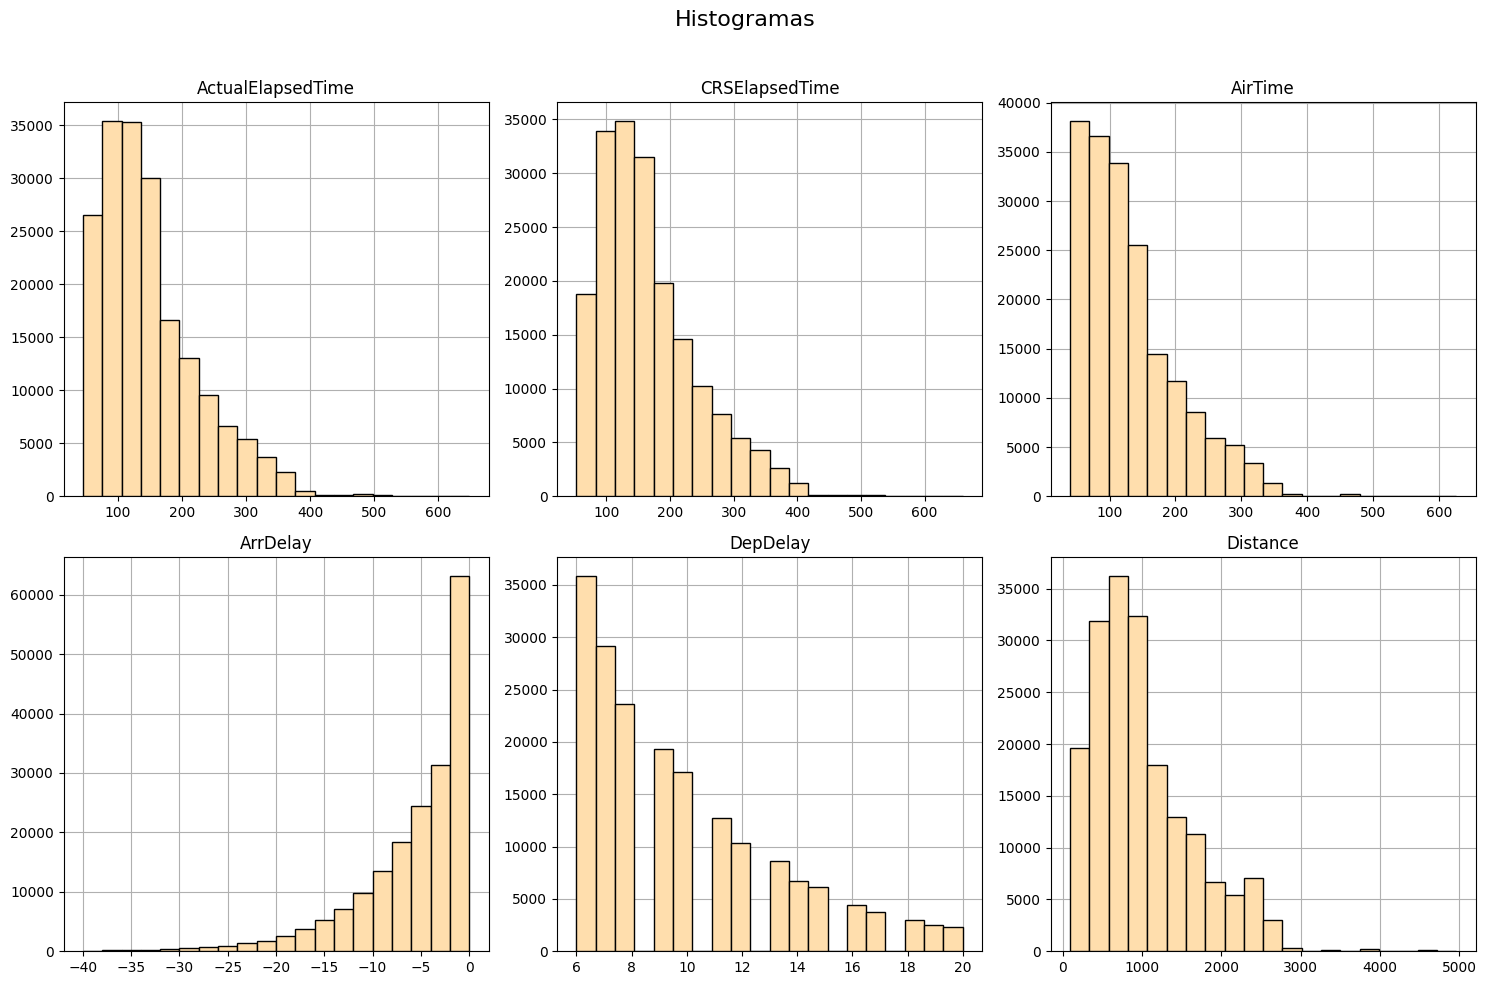

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in zip(lista_var_continuas, axs.flatten()):
    df[i].hist(bins=20, edgecolor='black', color ='NavajoWhite',ax=ax, zorder=4)
    ax.set_title(f'{i}')
# Adiciona um título geral acima dos subgráficos
fig.suptitle('Histogramas', fontsize=16, zorder=1)  # Definindo zorder para o título geral

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o espaço para acomodar o título geral

plt.show()

Podemos notar semelhanças entre o histograma do tempo real e programado de voo, com grande diferença para os voos mais rápidos, onde o real supera o programado. O maior volume de atrasos na partida são menores que oito minutos. Apesar de ocorrer voos que chegam adiantados, a grande parte são com menos de cinco minutos de adiantamento.

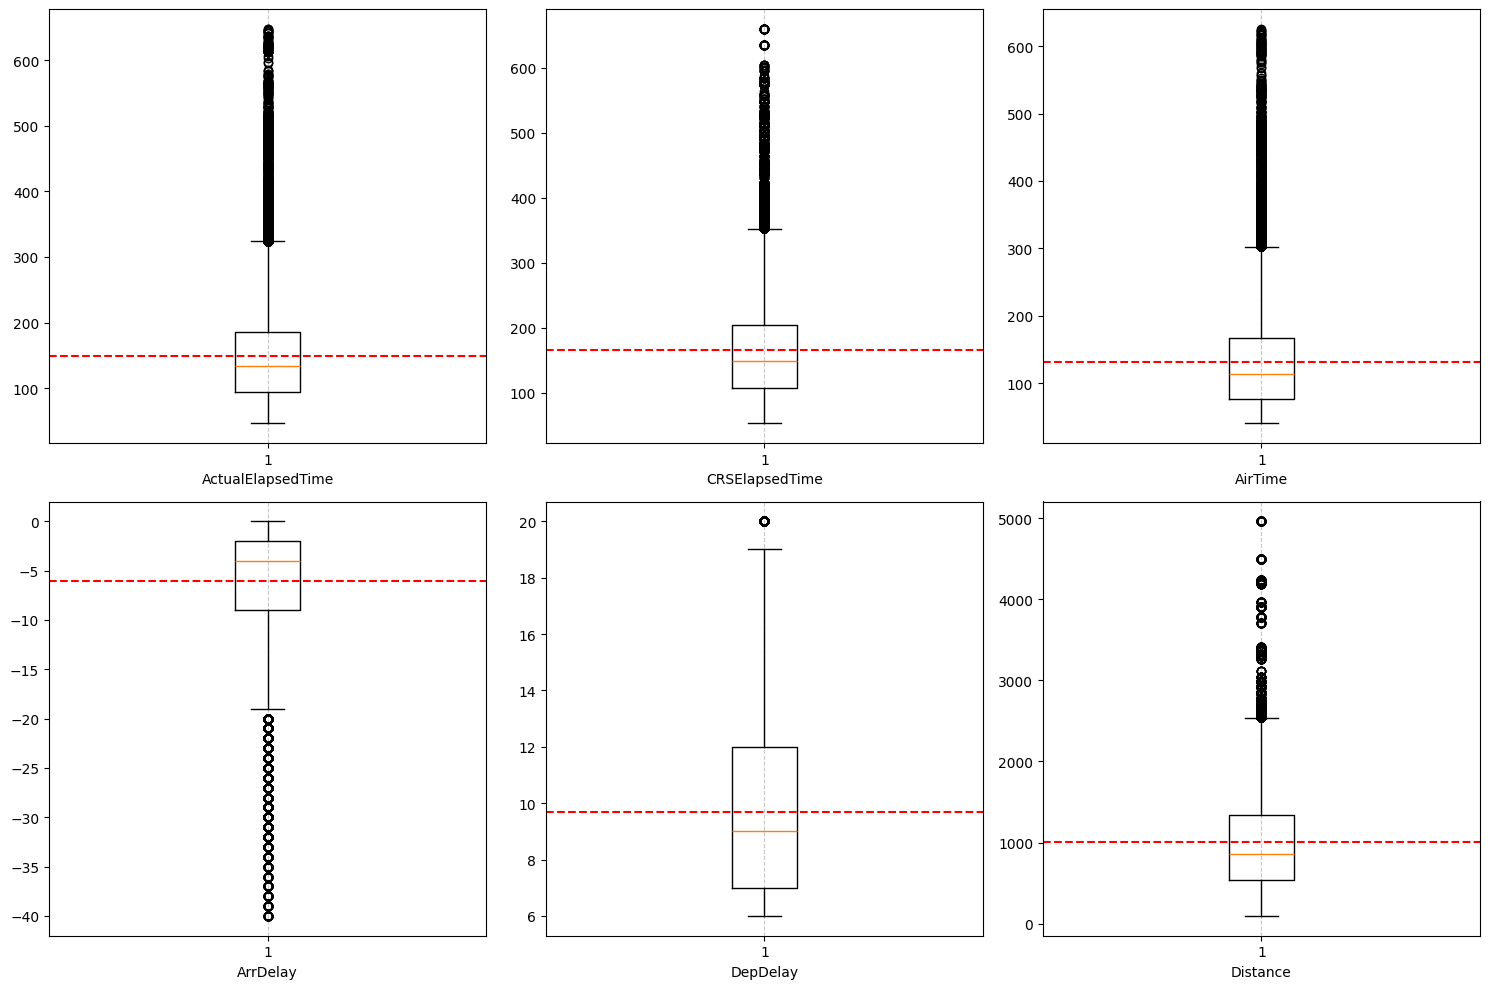

In [31]:
fig = plt.figure(figsize = (15,10))

for i, col in enumerate(df[lista_var_continuas]):
    plt.subplot(2,3,i+1)
    plt.boxplot(df[col])
    plt.xlabel(col)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.axhline(y=df[col].mean(), linestyle='--', color="red")
    
plt.tight_layout()     
plt.show()

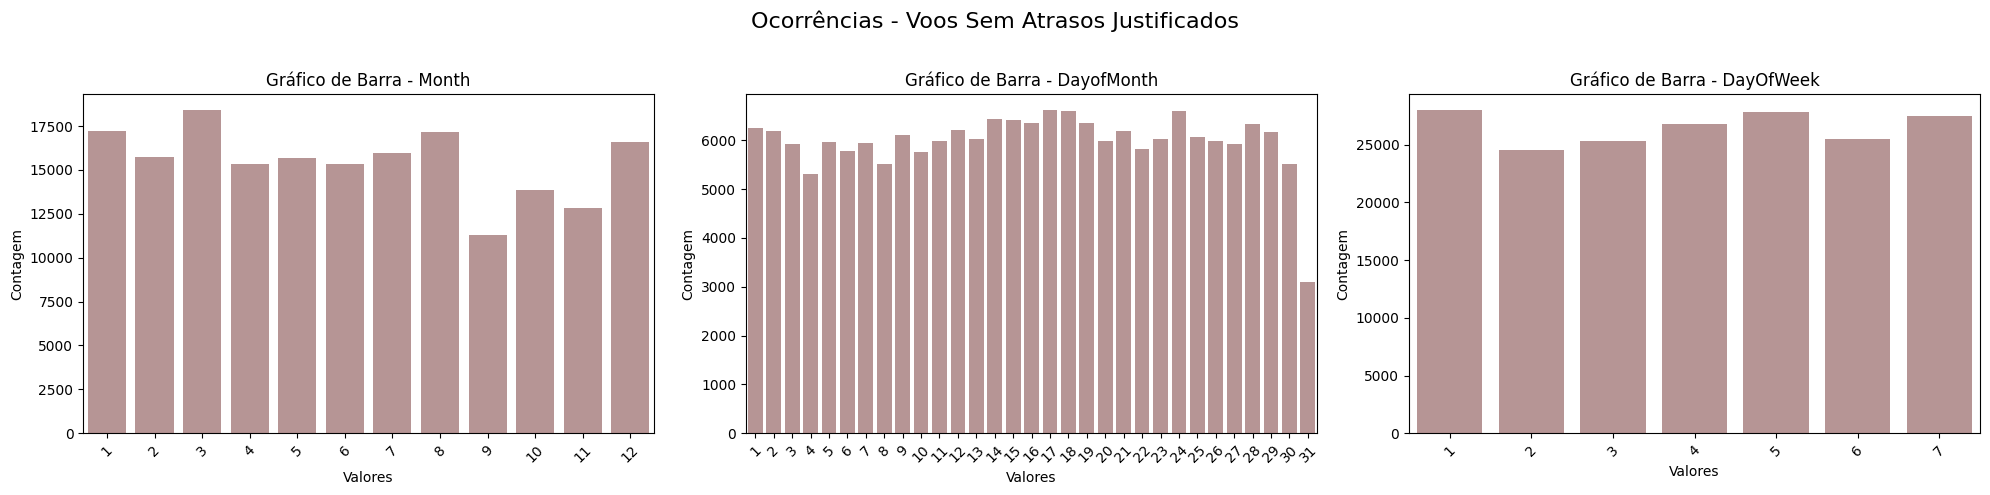

In [32]:
# Criar gráficos de barra para variáveis discretas
fig, axs =plt.subplots(1,3, figsize = (20,5))

for i, ax in zip(lista_var_discretas, axs.flatten()):
    sns.countplot(x=i, data=df[[i]], ax=ax, color='RosyBrown')
    ax.set_title(f'Gráfico de Barra - {i}')
    ax.set_xlabel('Valores')
    ax.set_ylabel('Contagem')

    # Ajusta a rotação dos rótulos para melhor legibilidade
    ax.tick_params(axis='x', rotation=45)
# Adiciona um título geral acima dos subgráficos
fig.suptitle('Ocorrências - Voos Sem Atrasos Justificados', fontsize=16)
# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o espaço para acomodar o título geral

# Exibe a figura
plt.show()

Podemos observar que o mês que ocorrem menos voos que chegam adiantados é o mês de setembro e março o mês com maior ocorrência. O dia 31 apresenta uma queda de ocorrência devido o fato de não ter 31 em metade dos meses do ano. A segunda feita ocorre mais voos andiantados e terça ocorre a menor quantidade de voos adiantados.

### Análise dos voos pelo tempo de voo

In [33]:
min, q25, q50,q75, max = df['CRSElapsedTime'].describe()[['min', '25%', '50%','75%', 'max']]

In [34]:
df['Class_CRSElapsedTime'] = pd.cut(df['CRSElapsedTime'],
                                     bins=[min, q25, q50, q75, max],
                                     labels=['Voo Muito Curto', 'Voo Curto', 'Voo Longo', 'Voo Muito Longo'])

<Figure size 1000x600 with 0 Axes>

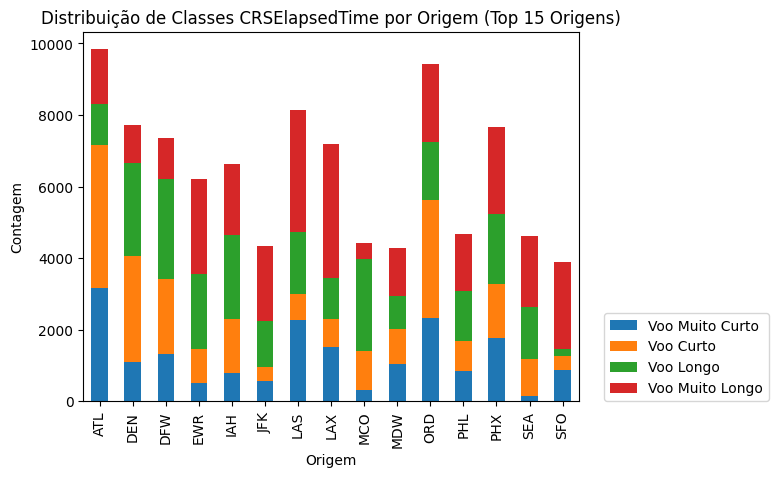

In [35]:
# Contar a frequência de cada origem
origem_counts = df['Origin'].value_counts().head(15).index

# Filtrar o DataFrame para incluir apenas as 10 principais origens
df_top_origins = df[df['Origin'].isin(origem_counts)]

# Criar DataFrame pivot para contar as ocorrências de cada combinação
df_pivot = df_top_origins.groupby(['Origin', 'Class_CRSElapsedTime']).size().unstack(fill_value=0)

# Criar gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
ax = df_pivot.plot(kind='bar', stacked=True)
plt.title('Distribuição de Classes CRSElapsedTime por Origem (Top 15 Origens)')
plt.xlabel('Origem')
plt.ylabel('Contagem')

ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()

Podemos observar, analisando os 15 aeroportos de destino com maior volume de voos andiantados que não há um padrão em relação ao tempo de voo. Há aeroportos com maior quantidade bde eventos de voos adiantados entre voos muito longos (LAS e LAX), porém para Atlanta (ATL) a maior concentração de voos adiantados está entre os voos curtos.

### Análise dos voos pelo tempo adiantado

In [40]:
min, q25, q50,q75, max = df['ArrDelay'].describe()[['min', '25%', '50%','75%', 'max']]

In [41]:
df['Class_ArrDelay'] = pd.cut(df['ArrDelay'],
                                     bins=[min, q25, q50, q75, max],
                                     labels=['Ínfimo','Mínimo', 'Considerável','Extremo'])

<Figure size 1000x600 with 0 Axes>

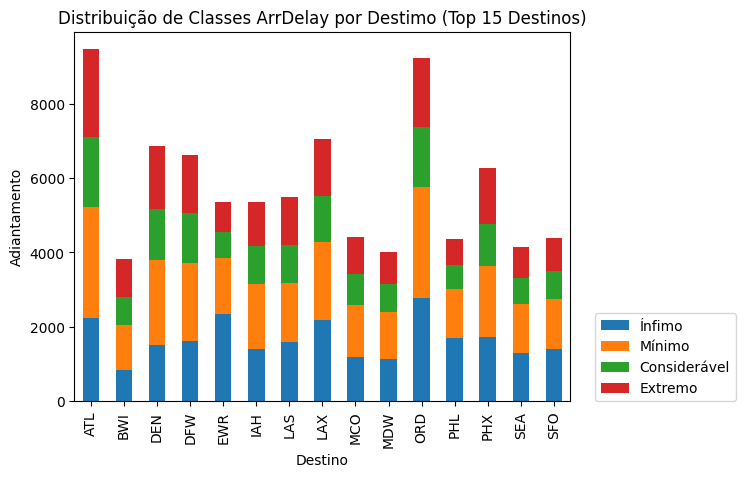

In [43]:

# Contar a frequência de cada destino
origem_counts = df['Dest'].value_counts().head(15).index

# Filtrar o DataFrame para incluir apenas as 10 principais origens
df_top_origins = df[df['Dest'].isin(origem_counts)]

# Criar DataFrame pivot para contar as ocorrências de cada combinação
df_pivot = df_top_origins.groupby(['Dest', 'Class_ArrDelay']).size().unstack(fill_value=0)

# Criar gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
ax = df_pivot.plot(kind='bar', stacked=True)
plt.title('Distribuição de Classes ArrDelay por Destimo (Top 15 Destinos)')
plt.xlabel('Destino')
plt.ylabel('Adiantamento')

ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()

Como foi observado no histograma, ocorrem adiantamento os voos com menos minitos adiantados.